<a href="https://colab.research.google.com/github/TheAmirHK/Portfolio-analysis-and-optimization/blob/main/Protifolio_Optimization_via_PyPortfolioOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""PyPortfolioOpt is a library that implements portfolio optimization methods, including classical efficient frontier techniques and Black-Litterman allocation,
as well as more recent developments in the field like shrinkage and Hierarchical Risk Parity,
along with some novel experimental features like exponentially-weighted covariance matrices.
"""

!pip3 install PyPortfolioOpt


In [2]:
import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [3]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import HRPOpt
from pypfopt.efficient_frontier import EfficientCVaR
import cvxpy as cp

In [4]:
# A function to download stocks' adjusted close price
def receive_data(tickers, start, end):
    adj_close_df = pd.DataFrame()
    for ticker in tickers:
        data = pdr.get_data_yahoo(ticker, start, end, progress=False)
        adj_close_df[ticker] = data["Adj Close"]
    return adj_close_df

In [5]:
# A function to normalize prices
def daily_return(data):
    log_returns = data.pct_change().dropna()
    return log_returns

In [6]:
# One portfolio test and evaluation
def evaluation  (data, Rf = 0.02, weights = None):
    result = pd.DataFrame()
    log_return = daily_return(data)
    if weights is None:
        result["ExpRet"] = log_return.mean()*252
        result["ExpVol"] = log_return.std() *np.sqrt(252)
        result["ExpSha"] = (result["ExpRet"] - Rf) / result["ExpVol"]
    else:
        result["ExpRet"] = [np.sum(log_return.mean()*weights)*252]
        result["ExpVol"] = [np.sqrt(weights.T @ log_return.cov() @ weights) * np.sqrt(252)]
        result["ExpSha"] = (result["ExpRet"] - Rf) / result["ExpVol"]
    return result

In [7]:
# Eahc individual stocks to be analyzed !
stocks = ["AAPL", "MSFT", "GOOG", "AMZN",   # Technology stocks
          "TSLA", "TM", "MBGYY", "VWAGY", "VLVLY", "GM",  # Motor manufacturing stocks
          "LLY", "JNJ", "AZN"] # Health market stocks

# define the number of years to be studied
NYears = 5

# Risk-free asset rate
Rf = 0.02

# Wealth value (Budget)
wealth = 5000

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
print("Start date:%str   End date:%str" %(start, end))

portfolio = receive_data(stocks, start, end)

Start date:2018-11-29 15:14:04.730982tr   End date:2023-11-28 15:14:04.730982tr


In [8]:
# Calculate optimal share volumes using the obtained weights from simulation.
def share_volume(weights, portfolio, wealth):
    evaluation = pd.DataFrame()
    evaluation['Price'] = portfolio.iloc[-2]
    da = DiscreteAllocation(weights, evaluation['Price'], total_portfolio_value = wealth)
    allocation, leftover = da.greedy_portfolio()
    Optimal_weights = pd.DataFrame.from_dict([weights])
    evaluation['Optimal Weights'] = Optimal_weights.T
    evaluation['Optimal Volume'] = pd.DataFrame.from_dict([allocation]).T
    evaluation['Total pay'] = evaluation['Optimal Volume'] * evaluation['Price']
    print("Not allocated budegt: %0.2f $ out of %0.2f $ "%(leftover,wealth ))
    print(evaluation.replace(np.nan, 0))
    return


Expected annual return: 43.0%
Annual volatility: 27.6%
Sharpe Ratio: 1.49
Not allocated budegt: 149.08 $ out of 5000.00 $ 
            Price  Optimal Weights  Optimal Volume    Total pay
AAPL   189.789993          0.19052             5.0   948.949966
MSFT   378.609985          0.00000             0.0     0.000000
GOOG   138.050003          0.00000             0.0     0.000000
AMZN   147.729996          0.00000             0.0     0.000000
TSLA   236.080002          0.17788             4.0   944.320007
TM     186.610001          0.00000             0.0     0.000000
MBGYY   15.930000          0.00000             0.0     0.000000
VWAGY   12.890000          0.00000             0.0     0.000000
VLVLY   22.889999          0.00000             0.0     0.000000
GM      28.500000          0.00000             0.0     0.000000
LLY    591.530029          0.63159             5.0  2957.650146
JNJ    151.279999          0.00000             0.0     0.000000
AZN     63.660000          0.00000           

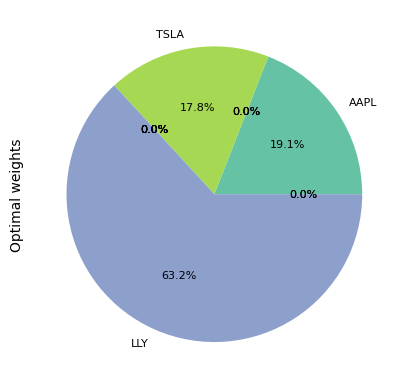

In [9]:
def MaxSharpe(data,wealth):
    mu = mean_historical_return(data)
    S = CovarianceShrinkage(data).ledoit_wolf()

    ef = EfficientFrontier(mu, S)
    ef.max_sharpe(risk_free_rate=0.02)

    weight_arr = ef.weights
    weights_max_sharpe = ef.clean_weights()
    ef.portfolio_performance(verbose=True)
    share_volume(weights_max_sharpe,data, wealth )
    Optimal_weights = pd.DataFrame.from_dict([weights_max_sharpe])
    Optimal_weights.iloc[0].plot(kind='pie',
                                 autopct='%1.1f%%',
                                 colors=sns.color_palette('Set2'),
                                 textprops={'fontsize':8}, ylabel = "Optimal weights")
    results = evaluation (data, weights = Optimal_weights.iloc[0].T)
    return results
MaxSharpe_results = MaxSharpe(portfolio,wealth)

Expected annual return: 19.9%
Annual volatility: 19.9%
Sharpe Ratio: 0.90
Not allocated budegt: 4.09 $ out of 5000.00 $ 
            Price  Optimal Weights  Optimal Volume   Total pay
AAPL   189.789993         0.081588               2  379.579987
MSFT   378.609985         0.063267               1  378.609985
GOOG   138.050003         0.080056               2  276.100006
AMZN   147.729996         0.063402               2  295.459991
TSLA   236.080002         0.032189               1  236.080002
TM     186.610001         0.107955               3  559.830002
MBGYY   15.930000         0.026927               8  127.440002
VWAGY   12.890000         0.027566              11  141.790004
VLVLY   22.889999         0.035067               7  160.229996
GM      28.500000         0.027767               4  114.000000
LLY    591.530029         0.085591               1  591.530029
JNJ    151.279999         0.197110               6  907.679993
AZN     63.660000         0.171516              13  827.5799

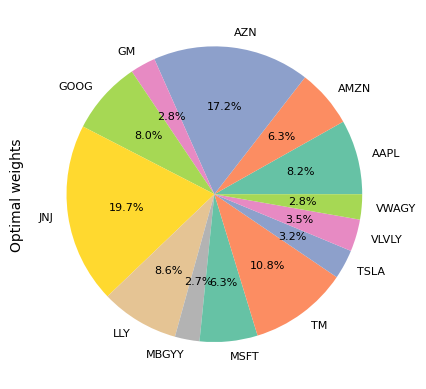

In [10]:
def Hierarchical_Risk_Parity (data,wealth):
    returns = data.pct_change().dropna()
    hrp = HRPOpt(returns)
    hrp_weights = hrp.optimize()
    results = hrp.portfolio_performance(verbose=True)
    share_volume(hrp_weights,data, 5000 )
    Optimal_weights = pd.DataFrame.from_dict([hrp_weights])
    Optimal_weights.iloc[0].plot(kind='pie',
                                 autopct='%1.1f%%',
                                 colors=sns.color_palette('Set2'),
                                 textprops={'fontsize':8}, ylabel = "Optimal weights")
    results = evaluation (data, weights = Optimal_weights.iloc[0].T)
    return results
HRP_results = Hierarchical_Risk_Parity(portfolio, wealth)

Not allocated budegt: 413.18 $ out of 5000.00 $ 
            Price  Optimal Weights  Optimal Volume    Total pay
AAPL   189.789993          0.00000             0.0     0.000000
MSFT   378.609985          0.00000             0.0     0.000000
GOOG   138.050003          0.00000             0.0     0.000000
AMZN   147.729996          0.00000             0.0     0.000000
TSLA   236.080002          0.00000             0.0     0.000000
TM     186.610001          0.00000             0.0     0.000000
MBGYY   15.930000          0.48020           150.0  2389.500046
VWAGY   12.890000          0.00000             0.0     0.000000
VLVLY   22.889999          0.00000             0.0     0.000000
GM      28.500000          0.00000             0.0     0.000000
LLY    591.530029          0.05865             0.0     0.000000
JNJ    151.279999          0.38964            12.0  1815.359985
AZN     63.660000          0.07151             6.0   381.959999


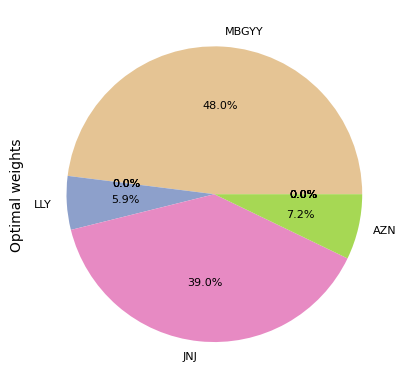

In [13]:
def Efficient_CVaR (data, wealth):
    mu = mean_historical_return(data)
    S = CovarianceShrinkage(data).ledoit_wolf()

    ef_cvar = EfficientCVaR(mu, S, solver=cp.ECOS)
    cvar_weights = ef_cvar.min_cvar()
    cleaned_weights = ef_cvar.clean_weights()
    Optimal_weights = pd.DataFrame.from_dict([cleaned_weights])
    Optimal_weights.iloc[0].plot(kind='pie',
                                 autopct='%1.1f%%',
                                 colors=sns.color_palette('Set2'),
                                 textprops={'fontsize':8}, ylabel = "Optimal weights")
    share_volume(cleaned_weights,data, 5000 )
    results = evaluation (data, weights = Optimal_weights.iloc[0].T)
    return results
CVaR_results = Efficient_CVaR(portfolio, wealth)

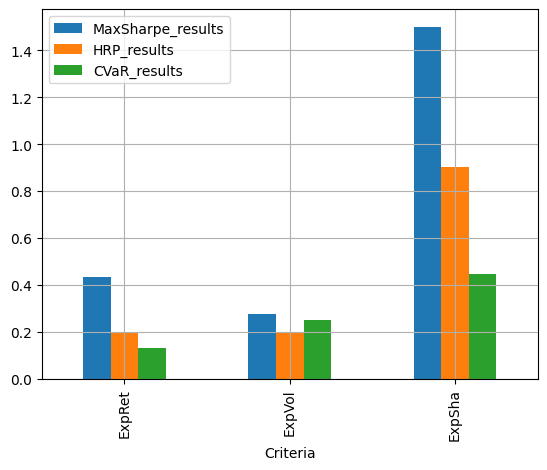

In [14]:
df = pd.DataFrame({
'Criteria': ['ExpRet', 'ExpVol', 'ExpSha'],
'MaxSharpe_results': MaxSharpe_results.iloc[0].values.tolist(),
'HRP_results': (HRP_results.iloc[0]).values.tolist(),
'CVaR_results': (CVaR_results.iloc[0]).values.tolist()
})

# plotting graph
df.plot(x="Criteria", y=["MaxSharpe_results", "HRP_results","CVaR_results" ], kind="bar", grid=True)
plt.show()